In this notebook, we are going to continue from the previous one where we had developed a simple linear neural net model for our character prediction task. In fact you could go far as saying that the previous notebook implemented a simple mapping of our context to probabilities of the next character, which we labelled our weight matrix, and which we then attempted to optimize using backprop using the negative log likelihood loss function. But a mistake with this mapping approach was that as our context size grew, that caused our matrix to grow exponentially, as each unique encoding was represented as a row. This meant that the matrix grew at a rate of $27^n$ where $n$ was the size of the context.

Therefore, in this notebook we try to rectify these issues by being smarter about our representation, and adding a hidden layer with non-linearity. This approach is inspired and attempts to closely follow the Bengio et al 2003 paper (https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). Thus, we will look to introduce an embedding matrix for our vocabulary (in our case that is 27 characters), that will map each word (character) to a $d$ dimensional space. Depending on the choice of context size ($n$), we will concatenate these $n$ vectors to produce a single input vector. This input vector will then be fed to the non-linear layer which will be made of $n_{in}$ neurons. The output of this hidden layer will be fed to a final layer that will be the size of our vocabulary so we can make a prediction. The output of this layer has to be passed through a softmax function to give proper probabilities for all options from our vocabulary. 

The output can then be used to calculate the loss using the negative log likelihood, and backprop can be used to optimize the parameters of the network and produce a better fitted model. It is worth noting that we have a few hyperparameters in this scenario including the context size, the dimensionality of the embedding space, the number of neurons in the hidden layer, the learning rate.

In [1]:
# read in our data
with open('names.txt') as f:
    words = f.read().splitlines()

len(words)

32033

In [2]:
# create a dictionary of all the characters in our dataset
chars = set(''.join(words))
ctoi = {c: i+1 for i, c in enumerate(chars)}
ctoi['.'] = 0
itoc = {i: c for c, i in ctoi.items()}

In [3]:
# create a function to shuffle, split, and build the dataset into a training, validation, and test set

import random
import torch
import matplotlib.pyplot as plt

random.seed(42) # set the random seed for reproducibility
random.shuffle(words)

def split_dataset(train_size=0.8, val_size=0.1, test_size=0.1):
    assert train_size + val_size + test_size == 1, 'train_size + val_size + test_size must equal 1'
    train_idx = int(len(words) * train_size)
    val_idx = int(len(words) * (train_size+val_size))
    return words[:train_idx], words[train_idx:val_idx], words[val_idx:]

def build_dataset(dataset, n=3):
    X, Y = [], []
    for word in dataset:
        context = [0] * n
        for c in word + '.':
            X.append(context)
            Y.append(ctoi[c])
            context = context[1:] + [ctoi[c]]

    return torch.tensor(X), torch.tensor(Y)

In [4]:
# generate out datasets
train_dataset, val_dataset, test_dataset = split_dataset()
train_X, train_Y = build_dataset(train_dataset, n=3)
val_X, val_Y = build_dataset(val_dataset, n=3)
test_X, test_Y = build_dataset(test_dataset, n=3)

In [5]:
# initialize our parameters
def init_params(emb_dims, hidden_neurons, context_size, vocab_size):
    g = torch.Generator().manual_seed(2147483647)
    C = torch.randn((vocab_size, emb_dims), generator=g)
    W1 = torch.randn((emb_dims*context_size, hidden_neurons), generator=g)
    b1 = torch.randn(hidden_neurons, generator=g)
    W2 = torch.randn((hidden_neurons, vocab_size), generator=g)
    b2 = torch.randn(vocab_size, generator=g)
    return [C, W1, b1, W2, b2]

In [6]:
# initialize our parameters and set requires_grad to True
params = init_params(emb_dims=10, hidden_neurons=300, context_size=3, vocab_size=len(ctoi))

for param in params:
    param.requires_grad = True

C, W1, b1, W2, b2 = params

In [7]:
print(f'Total number of parameters: {sum(param.nelement() for param in params)}')

Total number of parameters: 17697


In [8]:
# init arrays to monitor stats
train_losses = []
val_losses = []

In [9]:
batch_size = 32

lr = 0.1

reg_strength = 0

epochs = 40

max_steps = train_X.shape[0] // batch_size

Epoch: 1, Train Loss: 3.8534, Val Loss: 2.8652
Epoch: 2, Train Loss: 2.7021, Val Loss: 2.6152
Epoch: 3, Train Loss: 2.6307, Val Loss: 2.5876
Epoch: 4, Train Loss: 2.4149, Val Loss: 2.4340
Epoch: 5, Train Loss: 2.4370, Val Loss: 2.6276
Epoch: 6, Train Loss: 2.2664, Val Loss: 2.4633
Epoch: 7, Train Loss: 2.6941, Val Loss: 2.4237
Epoch: 8, Train Loss: 2.5056, Val Loss: 2.3875
Epoch: 9, Train Loss: 2.3287, Val Loss: 2.3902
Epoch: 10, Train Loss: 2.4607, Val Loss: 2.3660
Epoch: 11, Train Loss: 2.4129, Val Loss: 2.4226
Epoch: 12, Train Loss: 2.1833, Val Loss: 2.3238
Epoch: 13, Train Loss: 1.8875, Val Loss: 2.3440
Epoch: 14, Train Loss: 1.9650, Val Loss: 2.3748
Epoch: 15, Train Loss: 2.0984, Val Loss: 2.3780
Epoch: 16, Train Loss: 2.0020, Val Loss: 2.3629
Epoch: 17, Train Loss: 2.4816, Val Loss: 2.2827
Epoch: 18, Train Loss: 1.9055, Val Loss: 2.2935
Epoch: 19, Train Loss: 2.3624, Val Loss: 2.2518
Epoch: 20, Train Loss: 2.3753, Val Loss: 2.2618
Epoch: 21, Train Loss: 2.1467, Val Loss: 2.1452
E

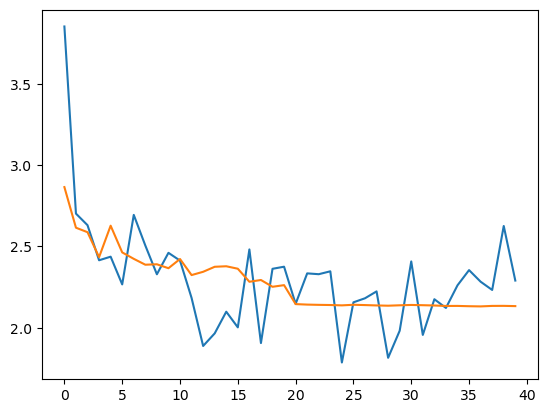

In [10]:
for epoch in range(epochs):
    if epoch == epochs//2:
        lr /= 10
    for step in range(0, max_steps):
        idx = torch.randint(0, train_X.shape[0], (batch_size,))
        emb = C[train_X[idx]].view(batch_size, -1)
        h = torch.tanh(emb @ W1 + b1)
        logits = h @ W2 + b2

        loss = torch.nn.functional.cross_entropy(logits, train_Y[idx]) + reg_strength * sum((param.data**2).mean() for param in params)

        for param in params:
            param.grad = None

        loss.backward()

        for param in params:
            param.data -= lr * param.grad

    train_losses.append(loss.item())

    with torch.no_grad():
        emb = C[val_X].view(val_X.shape[0], -1)
        h = torch.tanh(emb @ W1 + b1)
        logits = h @ W2 + b2

        loss = torch.nn.functional.cross_entropy(logits, val_Y) + reg_strength * sum((param.data**2).mean() for param in params)
        val_losses.append(loss.item())

    print(f'Epoch: {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

# plot the training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

In [22]:
emb = C[val_X].view(val_X.shape[0], -1)
h = torch.tanh(emb @ W1 + b1)
logits = h @ W2 + b2
loss = torch.nn.functional.cross_entropy(logits, val_Y)
loss

tensor(2.1328, grad_fn=<NllLossBackward0>)

In [23]:
emb = C[test_X].view(test_X.shape[0], -1)
h = torch.tanh(emb @ W1 + b1)
logits = h @ W2 + b2
loss = torch.nn.functional.cross_entropy(logits, test_Y)
loss

tensor(2.1330, grad_fn=<NllLossBackward0>)

We can also view the embeddings when we use $d = 2$

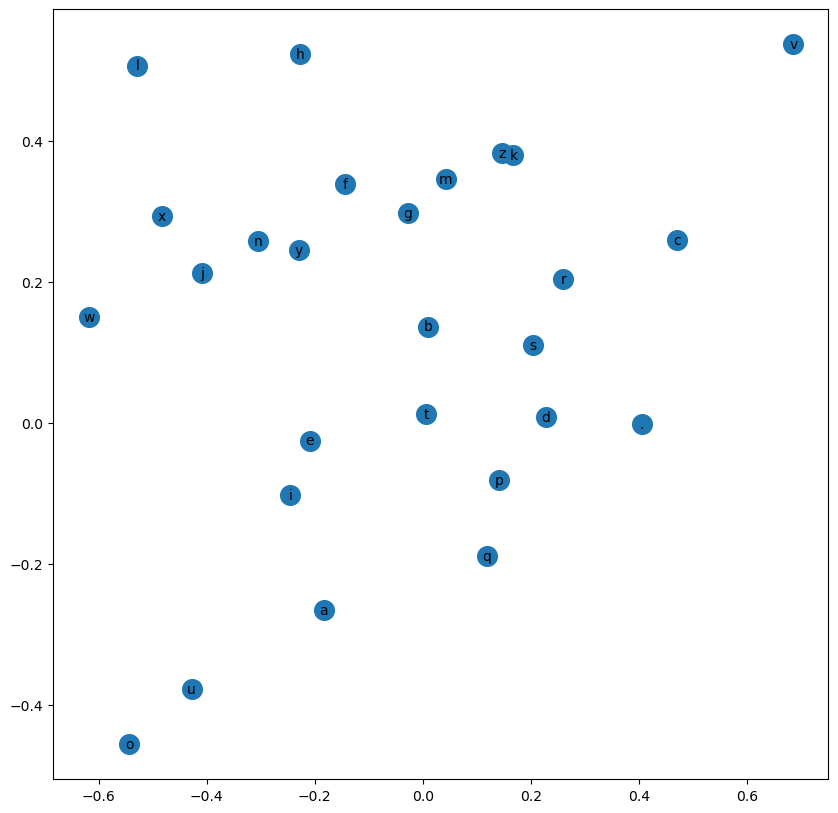

In [24]:
plt.figure(figsize=(10, 10))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)

for i in range(C.shape[0]):
    plt.annotate(itoc[i], (C[i, 0].data, C[i, 1].data), ha="center", va="center")

In [25]:
generator = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(10):
    context = [0]*3
    word = ''
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        p = torch.nn.functional.softmax(logits, dim=1)
        c = torch.multinomial(p, num_samples=1, generator=generator).item()
        if c == 0:
            break
        word += itoc[c]
        context = context[1:] + [c]
    print(word)

enslei
vid
naren
duri
nan
emnette
mestina
davlarone
abvin
stianna
